# BioNeMo - Geneformer inferencing for single cell downstream tasks

This tutorial showcases how to run the BioNeMo container, pre-train a geneformer model, and use it for inferencing downstream single cell tasks. At the end of this tutorial, a user will learn:
- launching the BioNeMo container
- Download data from czi to use for pre-training and inference.
- Convert AnnData files into the sparse CSR memmap format used by BioNeMo
- Kick-off pretraining with a custom single cell dataset
- Restore the pre-trained model and perform inference with the same czi dataset.


### Prerequisites:
- BioNeMo Framework container is running (refer to the [Quickstart Guide](../quickstart-fw.md))
- Familiarity with some components of the BioNeMo framework such as the [Models](../models/megamolbart.md) and [Inferencing](../inference-grpc-fw.md)


#### Running the BioNeMo container

This example has been built by launching the container in a local machine with 2 x A6000 RTX GPUs. Refer to specific instructions for [remote and multi-node launch]

Once the container is launched, navigate to http://0.0.0.0:8888, http://localhost:8888, or the IP address of the workstation/node. A JupyterLab instance should show up.

#### Copy this code and input files into JupyterLab

In the launched JupyterLab, run the codes in a Jupyter notebook as provided in the code cells below.

## Getting example single cell data and setting it up for inference

First, we must acquire single cell training data for inference. To do this we will install the cellxgene-census api and download a small dataset. We use the example provided by the czi api examples page to download a single h5ad file. Generally, our workflow expects a collection of h5ad files to be used for pre-training. In this case, we restrict to 100k cells from a single dataset  to keep training time and downloading time small.

In [1]:
!pip install cellxgene-census

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Below are paths required for setting up pre-training and inference.
tutorial_data_dir = "/workspace/bionemo/data/singlecell_tutorial/download_anndata"
tutorial_processed_dir = "/workspace/bionemo/data/singlecell_tutorial/processed_data"
tutorial_output_dir = "/workspace/bionemo/data/singlecell_tutorial/inference_output"
tutorial_output_inference_pickle = f"{tutorial_output_dir}/human_covid19_bcells_from_scratch.pkl"
demo_data_download_path = f"{tutorial_data_dir}/human_covid19_bcells.h5ad"

In [3]:
!mkdir -p {tutorial_data_dir}
!mkdir -p {tutorial_processed_dir}
!mkdir -p {tutorial_output_dir}

In [4]:
import cellxgene_census

with cellxgene_census.open_soma(census_version="2023-12-15") as census:
    filter1 = "cell_type == 'B cell' and tissue_general == 'lung' and disease == 'COVID-19' and is_primary_data == True"

    adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        obs_value_filter = filter1,
        column_names = {"obs": ["assay", "cell_type", "tissue", "tissue_general", "suspension_type", "disease"]},
    )

    adata[:100000].write(demo_data_download_path)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209:

In [5]:
!ls -laht {demo_data_download_path}

-rw-r--r-- 1 jstjohn domain-users 27M Apr 29 16:11 /workspace/bionemo/data/singlecell_tutorial/download_anndata/human_covid19_bcells.h5ad


In [6]:
!python /workspace/bionemo/bionemo/data/singlecell/sc_memmap.py \
  --data-path {tutorial_data_dir} \
  --save-path {tutorial_processed_dir}

Found 1 files
Starting to create memmap files...
Metadata already exists, loading...
Writing data into memmaps to /workspace/bionemo/data/singlecell_tutorial/processed_data...
Merging AnnData into numpy memaps...: 100%|███████| 1/1 [00:00<00:00,  7.53it/s]
Saving dataframe ...
Done creating dataset ...


In [7]:
!ls -laht {tutorial_processed_dir}

total 18M
-rw-r--r-- 1 jstjohn domain-users 107K Apr 29 16:11 features.csv
-rw-r--r-- 1 jstjohn domain-users 8.5M Apr 29 16:11 gene_expression_ind.npy
-rw-r--r-- 1 jstjohn domain-users  19K Apr 29 16:11 gene_expression_ptr.npy
-rw-r--r-- 1 jstjohn domain-users 8.5M Apr 29 16:11 gene_expression_data.npy
drwxr-xr-x 5 jstjohn domain-users 4.0K Apr 26 18:55 ..
drwxr-xr-x 2 jstjohn domain-users 4.0K Apr 26 18:46 .
-rw-r--r-- 1 jstjohn domain-users 764K Apr 26 18:46 metadata.json


# Pretraining
Now that we have aquired the h5ad files we would like to use for training and converted them to a sparse memmap. We will kickoff training. This involves two distinct steps
- preprocessing (indicated with do_training=False), where artifacts are downloaded from huggingface to be used by the model. Importantly, we set the `dataset_path` to be the same place we created the sparse memmap files. This is how BioNeMo knows where to find files for training, including both training data and additional artifacts (such as tokenizers).
- pretraining, where the model is actually trained.

We set the flag `max_steps` to limit the runtime. Check the full config file in `examples/singlecell/geneformer/conf` for a complete list of arguments.

In [8]:
# Run preprocessing to acquire the requisite files for pre-training.
!python /workspace/bionemo/examples/singlecell/geneformer/pretrain.py \
  ++model.data.dataset_path={tutorial_processed_dir} \
  ++do_training=False

[NeMo W 2024-04-29 16:11:41 nemo_logging:349] /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
      self.pid = os.fork()
    
[NeMo I 2024-04-29 16:11:43 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-04-29 16:11:43 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-04-29 16:11:43 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'geneformer_config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
      warnings.warn(msg, UserWarning)
    
[NeMo W 2024-04-29 16:11:43

In [9]:
# Pretrain the model using
!python /workspace/bionemo/examples/singlecell/geneformer/pretrain.py \
  --config-dir /workspace/bionemo/examples/singlecell/geneformer/conf \
  --config-name geneformer_config \
  ++model.data.dataset_path={tutorial_processed_dir} \
  ++trainer.devices=1 \
  ++trainer.max_steps=200 \
  ++exp_manager.exp_dir={tutorial_output_dir} \
  ++model.data.output_fname={tutorial_output_inference_pickle} \
  ++exp_manager.wandb_logger_kwargs.offline=True \
  ++exp_manager.resume_if_exists=False \
  ++do_training=True

[NeMo W 2024-04-29 16:11:59 nemo_logging:349] /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
      self.pid = os.fork()
    
[NeMo I 2024-04-29 16:12:01 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-04-29 16:12:01 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-04-29 16:12:01 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'geneformer_config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
      warnings.warn(msg, UserWarning)
    
[NeMo W 2024-04-29 16:12:01

# Running inference.

We can see from the above training job that the model was trained for a short number of steps. Note the end of the log file the experiment manager leaves a message about where the resulting `.nemo` file is written. This file is used for finetuning, inference, or training from an existing set of model weights. See the example produced below from our run:

```text
[NeMo I 2024-04-26 22:02:36 nemo_model_checkpoint:183] New .nemo model saved to: /workspace/bionemo/data/singlecell_tutorial/inference_output/geneformer/2024-04-26_22-02-05/checkpoints/geneformer.nemo
[NeMo I 2024-04-26 22:02:36 nlp_overrides:412] Removing checkpoint: /workspace/bionemo/data/singlecell_tutorial/inference_output/geneformer/2024-04-26_22-02-05/checkpoints/geneformer--val_loss=8.70-step=100-consumed_samples=800.0-last.ckpt
Epoch 0: 100%|█| 200/200 [00:27<00:00,  7.17it/s, v_num=2-05, reduced_train_loss`Trainer.fit` stopped: `max_steps=200` reached.
Epoch 0: 100%|█| 200/200 [00:27<00:00,  7.17it/s, v_num=2-05, reduced_train_loss
```

We will take the `.nemo` file logged:
`/workspace/bionemo/data/singlecell_tutorial/inference_output/geneformer/2024-04-26_22-02-05/checkpoints/geneformer.nemo`

and use this for inference.

In [13]:
pretrained_nemo_file = '/workspace/bionemo/data/singlecell_tutorial/inference_output/geneformer/2024-04-29_16-12-01/checkpoints/geneformer.nemo'

In [14]:
!python /workspace/bionemo/bionemo/model/infer.py \
  --config-dir /workspace/bionemo/examples/singlecell/geneformer/conf \
  --config-name infer \
  ++model.downstream_task.restore_from_path={pretrained_nemo_file} \
  ++model.data.dataset_path={tutorial_processed_dir} \
  ++exp_manager.exp_dir={tutorial_output_dir} \
  ++model.data.output_fname={tutorial_output_inference_pickle} 

[NeMo W 2024-04-29 16:14:59 nemo_logging:349] /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
      self.pid = os.fork()
    
[NeMo I 2024-04-29 16:15:00 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-04-29 16:15:00 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo W 2024-04-29 16:15:01 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-04

# Load inference result and cluster with UMAP.
Now we will inspect our result. First, we expect there to be one prediction for each cell, we can compare the shape of the anndata object to the predictions produced by our model. After this, we can simply pass our embeddings into umap, and view the result! In this case its a very poorly trained model with very few cells, so keep expectations low!

The inference_results pickle file contains one set of hiddens and embeddings for each cell. The hiddens contain the embedding per-token, whereas the embeddings contain the mean embedding for all gene tokens with special tokens (CLS, MASK, etc) removed.

In [15]:
import pickle
with open(tutorial_output_inference_pickle, 'rb') as inference_handle:
    inference_results = pickle.load(inference_handle)
len(inference_results), adata.shape, inference_results[0].keys()

(2313,
 (2313, 60664),
 dict_keys(['text', 'types', 'padding_mask', 'labels', 'loss_mask', 'is_random', 'hiddens', 'embeddings']))

In [16]:
inference_results[0]['embeddings'].shape

(256,)

In [17]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform([x['embeddings'] for x in inference_results])

In [18]:
embedding.shape

(2313, 2)

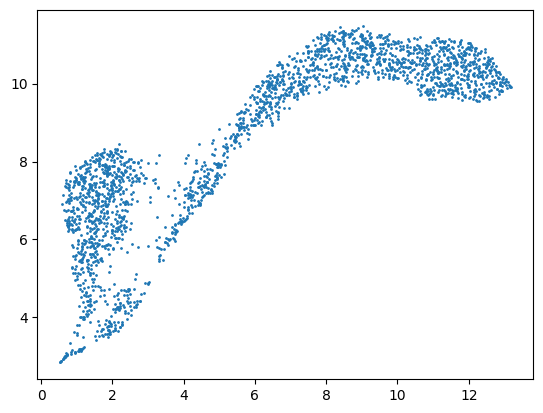

In [19]:
from matplotlib import pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1
)